In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import pandas as pd
import networkx as nx
import scipy as sp

#see https://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/

In [3]:
loc = 'datasets'

lines       = pd.read_csv('{}/london.lines.csv'.format(loc), index_col=0)
stations    = pd.read_csv('{}/london.stations.csv'.format(loc), index_col=0)
connections = pd.read_csv('{}/london.connections.csv'.format(loc))

In [4]:
#make a simple graph for each line

line_graphs = {}

for line_no in lines.index.values:
    
    current_line = connections.loc[connections['line'] == line_no]

    line_graphs[lines.loc[line_no]['name']] = nx.Graph()

    for connection_id, connection in current_line.iterrows():
        station1_name = stations.ix[connection['station1']]['name']
        station2_name = stations.ix[connection['station2']]['name']
        line_graphs[lines.loc[line_no]['name']].add_edge(station1_name, station2_name, time = connection['time'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [5]:
#add all the lines to make the full network multi-graph

full_map = nx.MultiGraph()

for current_line in line_graphs.values():
    full_map.add_edges_from(current_line.edges)

In [19]:
full_graph = full_map
structure = line_graphs['Bakerloo Line']

full_graph.nodes, structure.nodes

(NodeView(('Baker Street', 'Marylebone', "Regent's Park", 'Edgware Road (B)', 'Oxford Circus', 'Charing Cross', 'Embankment', 'Picadilly Circus', 'Waterloo', 'Paddington', 'Warwick Avenue', 'Elephant & Castle', 'Lambeth North', 'Harlesden', 'Stonebridge Park', 'Willesden Junction', 'Wembley Central', 'Kensal Green', 'Harrow & Wealdston', 'Kenton', 'South Kenton', "Queen's Park", 'Kilburn Park', 'North Wembley', 'Maida Vale', 'Aldgate', 'Liverpool Street', 'Tower Hill', 'Moorgate', 'Monument', 'Edgware Road (C)', 'Great Portland Street', 'Euston Square', 'Barbican', 'Farringdon', "King's Cross St. Pancras", 'Bayswater', 'Notting Hill Gate', 'High Street Kensington', 'Blackfriars', 'Mansion House', 'Temple', 'Cannon Street', 'Westminster', "St. James's Park", 'Gloucester Road', 'South Kensington', 'Sloane Square', 'Victoria', 'Aldgate East', 'Whitechapel', 'Stepney Green', 'Barking', 'East Ham', 'Upton Park', 'Bow Road', 'Bromley-By-Bow', 'Mile End', 'West Ham', 'Plaistow', 'Royal Oak', 

In [36]:
class StructGraph: #class to describe graphs with sub-strcutres, e.g. lines.
    def __init__(self, full_graph, structure):
        self.full = full_graph
        self.structure = structure
        self.big_struc = nx.Graph() #make the strcuture graph include all nodes from the full graph
        self.big_struc.add_nodes_from(full_graph)
        self.big_struc.add_edges_from(structure)
        
        self.stoc_mat = None
        self.adj_mat = None
        
        self.struc_sink = None

    def get_adj_mat(self):
        if self.adj_mat == None:
            self.adj_mat = nx.convert_matrix.to_numpy_matrix(self.full_graph)
        return self.adj_mat
        
    def get_stoc_mat(self):
        if self.stoc_mat == None:
            adj_mat = get_adj_mat(self)
            self.stoc_mat = adj_mat/np.sum(adj_mat, axis=0)
        return self.stoc_mat
        
    def get_struc_sink(self):
        if self.struc_sink == None:
            struc_adj_mat = nx.convert_matrix.to_numpy_matrix(struc_adj_mat)
            row = np.sum(struc_adj_mat, axis=1)
            self.struc_sink = np.logical_not((row.astype(bool))).astype(int)
        return self.struc_sink
    
    def return_times(self, initial, max_iter=100):
        step_mat = get_stoch_mat(self)
        sink = get_struc_sink(self)
        
        state = initial
        
        remaining_p = []
        remaining_p.append(np.sum(state))

        for i in range(max_iter):
            state = np.dot(step_mat, state)
            state = np.dot(sink, state)
            remaining_p.append(np.sum(state))
            
        return np.array(remaining_p)

In [152]:
#find the diffusion from the lines, using transfer matrix, initial population

In [ ]:
#find the return times to the line, using intial populations andd transfer matrices - modified to remove walkers
# i.e. set the components of the transfer matrix on the line to zero and they will act as sink, measure the proportion lost each interation.

In [6]:
G = nx.Graph()
G.add_nodes_from(['A', 'B'])
G.add_edges_from([('D', 'E'), ('A', 'E')])


G_big = nx.Graph()
G_big.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F'])
G_big.add_edges_from([('D', 'E'), ('A', 'E'),  ('F', 'C')])

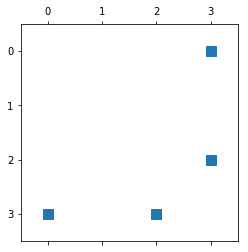

In [7]:
plt.spy(nx.adjacency_matrix(G))

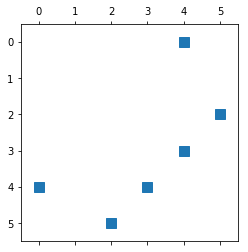

In [8]:
plt.spy(nx.adjacency_matrix(G_big))

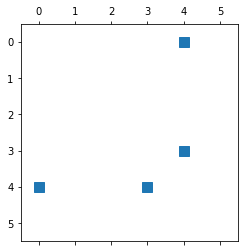

In [9]:
G_test = nx.Graph()
G_test.add_nodes_from(G_big)
G_test.add_edges_from(G.edges)
plt.spy(nx.adjacency_matrix(G_test))

In [33]:
adj_mat_test = nx.convert_matrix.to_numpy_matrix(G_test)
adj_mat_test[0, 4] += 1
row = np.sum(adj_mat_test, axis=1)
sink = np.logical_not((row.astype(bool))).astype(int)
sink, adj_mat_test

(matrix([[0],
         [1],
         [1],
         [0],
         [0],
         [1]]), matrix([[0., 0., 0., 0., 2., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]))

In [32]:
row = np.sum(adj_mat_test, axis=1)
sink = np.logical_not((row.astype(bool))).astype(int)
sink

matrix([[0],
        [1],
        [1],
        [0],
        [0],
        [1]])

In [44]:
np.dot(b, a)

array([6., 4., 6.])

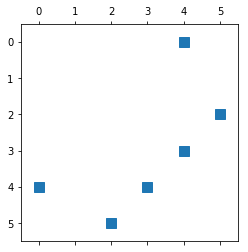

In [50]:
plt.spy(nx.adj_matrix(G_big))

In [68]:
test = nx.MultiGraph()
test.add_nodes_from(['A', 'B', 'C', 'D'])
test.add_edges_from([('A', 'B'), ('A', 'B'), ('A', 'C'), ('B', 'C'), ('D', 'C')])

test

adj_mat = nx.convert_matrix.to_numpy_matrix(test)
stoch_mat = adj_mat/np.sum(adj_mat, axis=0)
stoch_mat, np.sum(stoch_mat, axis=1)

(matrix([[0.        , 0.66666667, 0.33333333, 0.        ],
         [0.66666667, 0.        , 0.33333333, 0.        ],
         [0.33333333, 0.33333333, 0.        , 1.        ],
         [0.        , 0.        , 0.33333333, 0.        ]]),
 matrix([[1.        ],
         [1.        ],
         [1.66666667],
         [0.33333333]]))

In [69]:
stoch_mat

matrix([[0.        , 0.66666667, 0.33333333, 0.        ],
        [0.66666667, 0.        , 0.33333333, 0.        ],
        [0.33333333, 0.33333333, 0.        , 1.        ],
        [0.        , 0.        , 0.33333333, 0.        ]])

In [70]:
step_mat = stoch_mat
state = np.array([[0], [0], [0], [1]])

remaining_p = []
remaining_p.append(np.sum(state))
print(state)

for i in range(4):
    state = np.dot(step_mat, state)
    print(state)
    remaining_p.append(np.sum(state))

[[0]
 [0]
 [0]
 [1]]
[[0.]
 [0.]
 [1.]
 [0.]]
[[0.33333333]
 [0.33333333]
 [0.        ]
 [0.33333333]]
[[0.22222222]
 [0.22222222]
 [0.55555556]
 [0.        ]]
[[0.33333333]
 [0.33333333]
 [0.14814815]
 [0.18518519]]


In [67]:
2/9

0.2222222222222222

NameError: name 'xyz' is not defined